In [ ]:
pip install catboost

In [ ]:
# Импорт библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE

from sklearn.metrics import balanced_accuracy_score, f1_score

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cards = pd.read_csv('/content/drive/MyDrive/Credit Card//creditcard.csv')

# Первые строки датафрейма:
cards.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# Основная информация по датафрейму:
cards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
# Проверка кол-ва пропусков и дубликатов
print(f'Пропущено значений: {cards.isna().sum().sum()}')
print(f'Дубликатов: {cards.duplicated().sum()}')

Пропущено значений: 0
Дубликатов: 1081


In [ ]:
# Избавление от дубликатов
cards.drop_duplicates(inplace=True)
print(f'Дубликатов: {cards.duplicated().sum()}')

Дубликатов: 0


<Axes: >

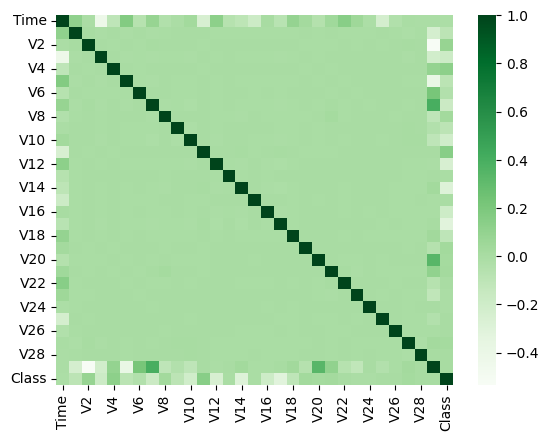

In [ ]:
# Оценка корреляции признаков
sns.heatmap(cards.corr(), cmap='Greens')

Корреляция между признаками *практически* отсутствует. Есть незначительная корреляция с признаками `Time`, `Amount`, `Class`.

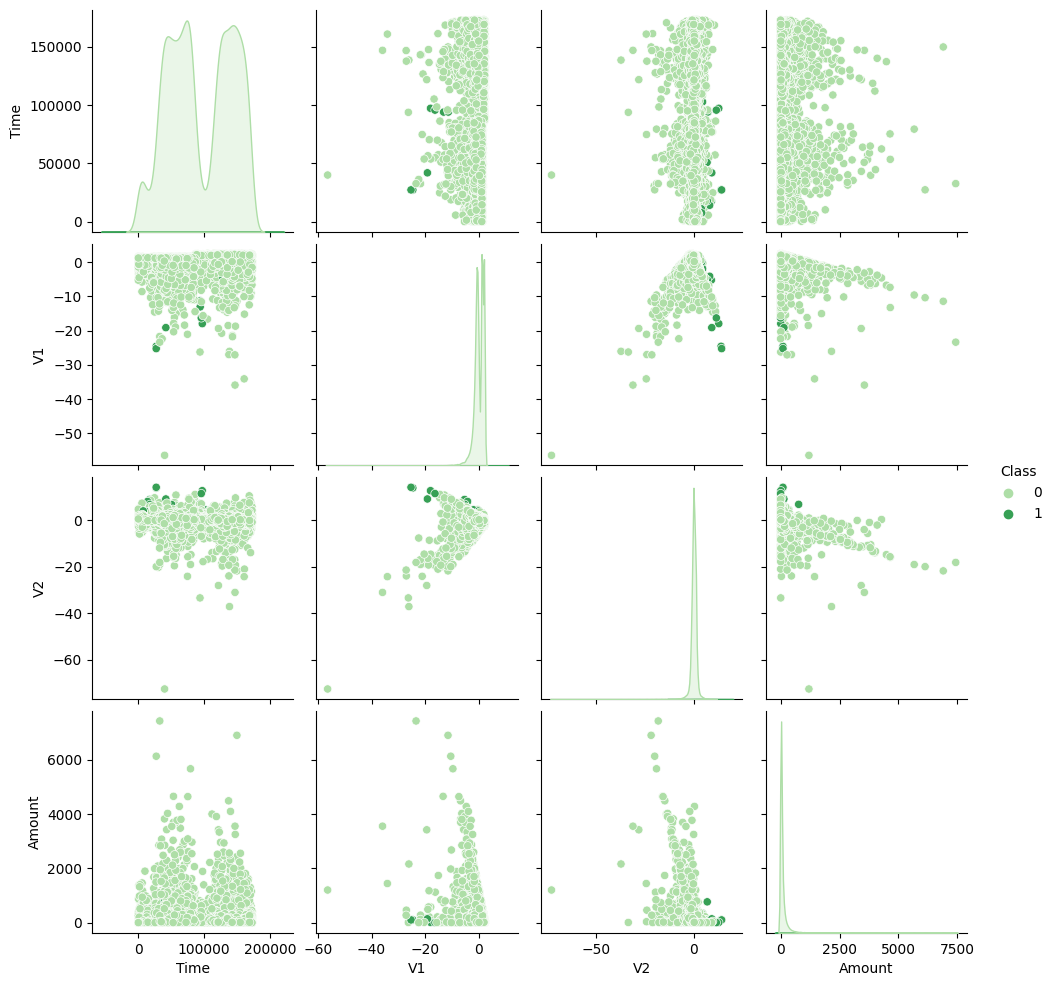

In [ ]:
# Исследование попарных зависимостей признаков на части данных (10 % данных)

sns.pairplot(cards.sample(frac=0.1).iloc[:, [0, 1, 2, 29, 30]], hue='Class', palette='Greens')

Уже на данном этапе можно оценить большую несбалансированность данных. Проверим это целенаправленно.

In [ ]:
# Сбалансированность данных между значениями Class
blnc = cards['Class'].value_counts().tolist()
print(f'Класс 0 - No fraud - {blnc[0]} - {blnc[0] / len(cards) * 100:.2f} % от данных')
print(f'Класс 1 - Fraud - {blnc[1]} - {blnc[1] / len(cards) * 100:.2f} % от данных')

Класс 0 - No fraud - 283253 - 99.83 % от данных
Класс 1 - Fraud - 473 - 0.17 % от данных


Данные сильно несбалансированы. Для проведения работ с несбалансированными данными возможно применить различные техники недо- и пресэмплирования.

In [ ]:
# Основные статистики по базе данных
cards.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,...,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667
std,47481.047891,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,...,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,...,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,...,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,...,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


В решении будем сравнивать решения моделей логистической регрессии LogisticRegression и градиентный бустинг CatBoostClassifier.

In [ ]:
# Разделение данных для подготовки к ресэмплингу
X = cards.drop('Class', axis=1)
y = cards['Class']

print(X.shape[0], X.shape[1])
print(f'{y.mean()} - среднее значение целевой переменной')

283726 30
0.001667101358352777 - среднее значение целевой переменной


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=21)

Чтобы оценить качество полученных результатов, будем использовать метрики: сбалансированная точность и F1-мера. Выбор метрик обусловлен большой несбалансированностью данных.

## LogisticRegression

### Недосэмплирование

#### RandomUnderSampler

In [ ]:
# Недосэмплирование техникой RandomUnderSampler и сравнение данных
X_res, y_res = RandomUnderSampler().fit_resample(X_train, y_train)

print(X_res.shape[0], X_res.shape[1])
print(f'{y_res.mean()} - среднее значение целевой переменной')

762 30
0.5 - среднее значение целевой переменной


In [ ]:
# Модель LogisticRegression
model = LogisticRegression()
model.fit(X_res, y_res)
predict = model.predict(X_test)
print(f'RandomUnderSampler: Сбалансированная точность: {balanced_accuracy_score(y_test, predict)}')
print(f'RandomUnderSampler: F1-мера: {f1_score(y_test, predict)}')

RandomUnderSampler: Сбалансированная точность: 0.9139809000784318
RandomUnderSampler: F1-мера: 0.06326611308817714


#### NearMiss 1

In [ ]:
# Недосэмплирование техникой NearMiss и сравнение данных
X_res, y_res = NearMiss(version=1).fit_resample(X_train, y_train)

print(X_res.shape[0], X_res.shape[1])
print(f'{y_res.mean()} - среднее значение целевой переменной')

762 30
0.5 - среднее значение целевой переменной


In [ ]:
# Модель LogisticRegression
model = LogisticRegression()
model.fit(X_res, y_res)
predict = model.predict(X_test)
print(f'NearMiss_1: Сбалансированная точность: {balanced_accuracy_score(y_test, predict)}')
print(f'NearMiss_1: F1-мера: {f1_score(y_test, predict)}')

NearMiss_1: Сбалансированная точность: 0.8599600012892907
NearMiss_1: F1-мера: 0.018497109826589593


#### NearMiss 2

In [ ]:
# Недосэмплирование техникой NearMiss и сравнение данных
X_res, y_res = NearMiss(version=2).fit_resample(X_train, y_train)

print(X_res.shape[0], X_res.shape[1])
print(f'{y_res.mean()} - среднее значение целевой переменной')

762 30
0.5 - среднее значение целевой переменной


In [ ]:
# Модель LogisticRegression
model = LogisticRegression()
model.fit(X_res, y_res)
predict = model.predict(X_test)
print(f'NearMiss_2: Сбалансированная точность: {balanced_accuracy_score(y_test, predict)}')
print(f'NearMiss_2: F1-мера: {f1_score(y_test, predict)}')

NearMiss_2: Сбалансированная точность: 0.8636118406006867
NearMiss_2: F1-мера: 0.026347720575489682


### Пересэмплирование

#### RandomOverSampler

In [ ]:
# Пересэмплирование техникой RandomOverSampler и сравнение данных
X_res, y_res = RandomOverSampler().fit_resample(X_train, y_train)

print(X_res.shape[0], X_res.shape[1])
print(f'{y_res.mean()} - среднее значение целевой переменной')

453198 30
0.5 - среднее значение целевой переменной


In [ ]:
# Модель LogisticRegression
model = LogisticRegression()
model.fit(X_res, y_res)
predict = model.predict(X_test)
print(f'RandomOverSampler: Сбалансированная точность: {balanced_accuracy_score(y_test, predict)}')
print(f'RandomOverSampler: F1-мера: {f1_score(y_test, predict)}')

RandomOverSampler: Сбалансированная точность: 0.8758315157915094
RandomOverSampler: F1-мера: 0.05761641673243883


#### SMOTE

In [ ]:
# Пересэмплирование техникой SMOTE и сравнение данных
X_res, y_res = SMOTE().fit_resample(X_train, y_train)

print(X_res.shape[0], X_res.shape[1])
print(f'{y_res.mean()} - среднее значение целевой переменной')

453198 30
0.5 - среднее значение целевой переменной


In [ ]:
# Модель LogisticRegression
model = LogisticRegression()
model.fit(X_res, y_res)
predict = model.predict(X_test)
print(f'SMOTE: Сбалансированная точность: {balanced_accuracy_score(y_test, predict)}')
print(f'SMOTE: F1-мера: {f1_score(y_test, predict)}')

SMOTE: Сбалансированная точность: 0.8998687302481424
SMOTE: F1-мера: 0.14367816091954022


## CatBoostClassifier

### Недосэмплирование

#### RandomUnderSampler

In [ ]:
# Недосэмплирование техникой RandomUnderSampler и сравнение данных
X_res, y_res = RandomUnderSampler().fit_resample(X_train, y_train)

print(X_res.shape[0], X_res.shape[1])
print(f'{y_res.mean()} - среднее значение целевой переменной')

762 30
0.5 - среднее значение целевой переменной


In [ ]:
# Модель CatBoostClassifier
model = CatBoostClassifier(verbose=False) # без вывода данных обучения: verbose=False
model.fit(X_res, y_res)
predict = model.predict(X_test)
print(f'RandomUnderSampler: Сбалансированная точность: {balanced_accuracy_score(y_test, predict)}')
print(f'RandomUnderSampler: F1-мера: {f1_score(y_test, predict)}')

RandomUnderSampler: Сбалансированная точность: 0.917406921649494
RandomUnderSampler: F1-мера: 0.10367454068241469


#### NearMiss 1

In [ ]:
# Недосэмплирование техникой NearMiss и сравнение данных
X_res, y_res = NearMiss(version=1).fit_resample(X_train, y_train)

print(X_res.shape[0], X_res.shape[1])
print(f'{y_res.mean()} - среднее значение целевой переменной')

762 30
0.5 - среднее значение целевой переменной


In [ ]:
# Модель CatBoostClassifier
model = CatBoostClassifier(verbose=False) # без вывода данных обучения: verbose=False
model.fit(X_res, y_res)
predict = model.predict(X_test)
print(f'NearMiss_1: Сбалансированная точность: {balanced_accuracy_score(y_test, predict)}')
print(f'NearMiss_1: F1-мера: {f1_score(y_test, predict)}')

NearMiss_1: Сбалансированная точность: 0.8820343089478313
NearMiss_1: F1-мера: 0.02856109906001446


#### NearMiss 2

In [ ]:
# Недосэмплирование техникой NearMiss и сравнение данных
X_res, y_res = NearMiss(version=2).fit_resample(X_train, y_train)

print(X_res.shape[0], X_res.shape[1])
print(f'{y_res.mean()} - среднее значение целевой переменной')

762 30
0.5 - среднее значение целевой переменной


In [ ]:
# Модель CatBoostClassifier
model = CatBoostClassifier(verbose=False) # без вывода данных обучения: verbose=False
model.fit(X_res, y_res)
predict = model.predict(X_test)
print(f'NearMiss_2: Сбалансированная точность: {balanced_accuracy_score(y_test, predict)}')
print(f'NearMiss_2: F1-мера: {f1_score(y_test, predict)}')

NearMiss_2: Сбалансированная точность: 0.5009195789544773
NearMiss_2: F1-мера: 0.003243223978473546


### Пересэмплирование

#### RandomOverSampler

In [ ]:
# Пересэмплирование техникой RandomOverSampler и сравнение данных
X_res, y_res = RandomOverSampler().fit_resample(X_train, y_train)

print(X_res.shape[0], X_res.shape[1])
print(f'{y_res.mean()} - среднее значение целевой переменной')

453198 30
0.5 - среднее значение целевой переменной


In [ ]:
# Модель CatBoostClassifier
model = CatBoostClassifier(verbose=False) # без вывода данных обучения: verbose=False
model.fit(X_res, y_res)
predict = model.predict(X_test)
print(f'RandomOverSampler: Сбалансированная точность: {balanced_accuracy_score(y_test, predict)}')
print(f'RandomOverSampler: F1-мера: {f1_score(y_test, predict)}')

RandomOverSampler: Сбалансированная точность: 0.8639804012457004
RandomOverSampler: F1-мера: 0.7613636363636362


#### SMOTE

In [ ]:
# Пересэмплирование техникой SMOTE и сравнение данных
X_res, y_res = SMOTE().fit_resample(X_train, y_train)

print(X_res.shape[0], X_res.shape[1])
print(f'{y_res.mean()} - среднее значение целевой переменной')

453198 30
0.5 - среднее значение целевой переменной


In [ ]:
# Модель CatBoostClassifier
model = CatBoostClassifier(verbose=False) # без вывода данных обучения: verbose=False
model.fit(X_res, y_res)
predict = model.predict(X_test)
print(f'SMOTE: Сбалансированная точность: {balanced_accuracy_score(y_test, predict)}')
print(f'SMOTE: F1-мера: {f1_score(y_test, predict)}')

SMOTE: Сбалансированная точность: 0.8638391932109633
SMOTE: F1-мера: 0.6979166666666667


# Вывод:

Сравнивая одни и те же техники ресэмплинга между двумя моделями можем сделать вывод что логистическая регрессия дала лучшие результаты. Сравнивая техники ресэмплинга в блоке с применением логистической регрессии можем сделать вывод что лучший результат дают техники оверсэмплинга. Лучший результат по сбалансированной точности выдала техника RandomOverSampling по показателю сбалансированной точности.